# Third Classifier

This time, classify the data *only* using price data.

## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(font='monospace')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 150)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}
flag_cols = {x for x in df.columns if x.find('flag_') > -1}
ethnicity_cols = {x for x in df.columns if x.find('ethnicity_') > -1}

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## Execution
Use both Random Forests and Extra Trees to classify the data using all columns

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(price_cols | duration_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 48)


### Extra Trees

In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(etc_metrics.roc_auc.mean())
etc_metrics.loc[:, eval_columns]

0.5427843137254902


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.444444,0.912281,0.980392,0.333333,0.647059,"[0.0, 0.0196078431373, 0.0196078431373, 0.1372...","[0.166666666667, 0.166666666667, 0.33333333333...","[0.76, 0.758764818705, 0.69, 0.44482441206, 0...."
1,0.181818,0.842105,0.921569,0.166667,0.537582,"[0.0, 0.0196078431373, 0.0588235294118, 0.0588...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.72, 0.72, 0.64, 0.61, 0.563218137145, 0.472..."
2,0.000000,0.894737,1.000000,0.000000,0.393791,"[0.0, 0.352941176471, 0.372549019608, 0.411764...","[0.0, 0.166666666667, 0.166666666667, 0.166666...","[1.47009335967, 0.470093359668, 0.448130932429..."
3,0.113208,0.175439,0.137255,0.500000,0.490196,"[0.0, 0.0, 0.862745098039, 0.862745098039, 0.8...","[0.166666666667, 0.333333333333, 0.5, 0.666666...","[0.73, 0.583029449243, 0.531678933798, 0.37, 0..."
4,0.043478,0.228070,0.235294,0.166667,0.282680,"[0.0, 0.764705882353, 0.78431372549, 0.8235294...","[0.166666666667, 0.166666666667, 0.16666666666...","[0.79, 0.537204242227, 0.417746532509, 0.28639..."
5,0.266667,0.807018,0.862745,0.333333,0.735294,"[0.0, 0.0196078431373, 0.0588235294118, 0.1372...","[0.166666666667, 0.333333333333, 0.33333333333...","[0.83, 0.69697551082, 0.69, 0.525351631642, 0...."
6,0.166667,0.824561,0.901961,0.166667,0.473856,"[0.0, 0.0196078431373, 0.0588235294118, 0.0588...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.71653092511, 0.716530925113, 0.668597961582..."
7,0.166667,0.824561,0.901961,0.166667,0.547386,"[0.0, 0.0196078431373, 0.0196078431373, 0.1176...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.1...","[1.89244434933, 0.892444349325, 0.8, 0.4802340..."
8,0.000000,0.767857,0.860000,0.000000,0.650000,"[0.0, 0.02, 0.1, 0.14, 0.26, 0.44, 0.48, 0.62,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[1.87032891551, 0.870328915505, 0.58, 0.543599..."
9,0.000000,0.745455,0.820000,0.000000,0.670000,"[0.0, 0.02, 0.06, 0.16, 0.18, 0.22, 0.24, 0.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[1.66, 0.66, 0.535894457639, 0.529276037409, 0..."


In [7]:
etc_metrics.loc[:,  sorted(set(etc_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

missing_price:count               0.239699
missing_price_per_min:count       0.233456
missing_duration_in_mins:count    0.232095
duration_in_mins:std              0.016573
price:std                         0.016213
missing_price:std                 0.015806
missing_duration_in_mins:std      0.014942
price:count                       0.014898
price:max                         0.014437
missing_price_per_min:std         0.013684
price:mean                        0.013248
price:min                         0.012925
missing_price:mean                0.011081
missing_price:50%                 0.011004
missing_price:25%                 0.009972
duration_in_mins:count            0.009736
missing_price:min                 0.009490
duration_in_mins:min              0.008585
duration_in_mins:max              0.008576
duration_in_mins:mean             0.008220
dtype: float64

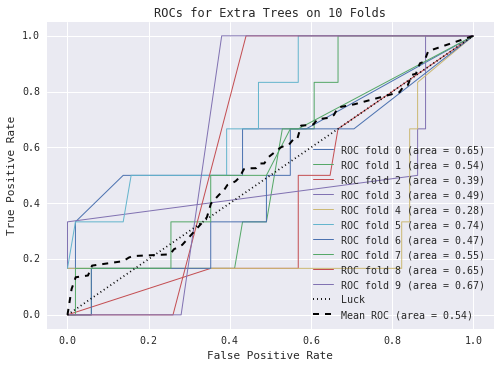

In [8]:
draw_rocs(etc_metrics, 'Extra Trees')

### Random Forest

In [9]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(rf_metrics.roc_auc.mean())
rf_metrics.loc[:, eval_columns]

0.5254640522875816


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.400000,0.894737,0.960784,0.333333,0.643791,"[0.0, 0.0196078431373, 0.0196078431373, 0.0392...","[0.0, 0.0, 0.333333333333, 0.333333333333, 0.5...","[1.71484714255, 0.714847142549, 0.65, 0.55, 0...."
1,0.181818,0.842105,0.921569,0.166667,0.568627,"[0.0, 0.0196078431373, 0.0392156862745, 0.0784...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.1...","[1.7, 0.7, 0.66, 0.563218137145, 0.47232480965..."
2,0.000000,0.877193,0.980392,0.000000,0.362745,"[0.0, 0.0196078431373, 0.372549019608, 0.41176...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.1...","[1.56027017891, 0.560270178911, 0.470093359668..."
3,0.113208,0.175439,0.137255,0.500000,0.490196,"[0.0, 0.0, 0.862745098039, 0.862745098039, 0.8...","[0.166666666667, 0.333333333333, 0.5, 0.666666...","[0.738960784314, 0.606682738671, 0.53167893379..."
4,0.043478,0.228070,0.235294,0.166667,0.264706,"[0.0, 0.764705882353, 0.78431372549, 0.8235294...","[0.166666666667, 0.166666666667, 0.16666666666...","[0.66, 0.537204242227, 0.417746532509, 0.28639..."
5,0.315789,0.771930,0.803922,0.500000,0.696078,"[0.0, 0.0392156862745, 0.0588235294118, 0.0980...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.3...","[1.86, 0.86, 0.714053524263, 0.603183841949, 0..."
6,0.000000,0.771930,0.862745,0.000000,0.359477,"[0.0, 0.0196078431373, 0.0392156862745, 0.0784...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.79961019302, 0.799610193024, 0.717499720843..."
7,0.307692,0.842105,0.901961,0.333333,0.549020,"[0.0, 0.0196078431373, 0.0588235294118, 0.0588...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.88016471016, 0.88016471016, 0.71, 0.7, 0.65..."
8,0.000000,0.732143,0.820000,0.000000,0.650000,"[0.0, 0.02, 0.12, 0.16, 0.26, 0.44, 0.48, 0.52...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[1.89, 0.89, 0.590910761692, 0.543599750307, 0..."
9,0.000000,0.745455,0.820000,0.000000,0.670000,"[0.0, 0.04, 0.06, 0.16, 0.18, 0.22, 0.24, 0.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[1.64, 0.64, 0.530037680145, 0.529276037409, 0..."


In [10]:
rf_metrics.loc[:,  sorted(set(rf_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

missing_price_per_min:count       0.251095
missing_price:count               0.249847
missing_duration_in_mins:count    0.236416
missing_price:std                 0.025669
price:std                         0.019890
price:max                         0.017719
missing_price_per_min:std         0.015249
missing_price:mean                0.014870
price:mean                        0.014842
price:min                         0.014609
price:count                       0.014524
missing_duration_in_mins:std      0.014350
duration_in_mins:std              0.013760
missing_duration_in_mins:mean     0.009300
price_per_min:mean                0.008306
price_per_min:count               0.008260
duration_in_mins:count            0.008089
missing_price_per_min:mean        0.007124
price_per_min:min                 0.006636
price_per_min:max                 0.006601
dtype: float64

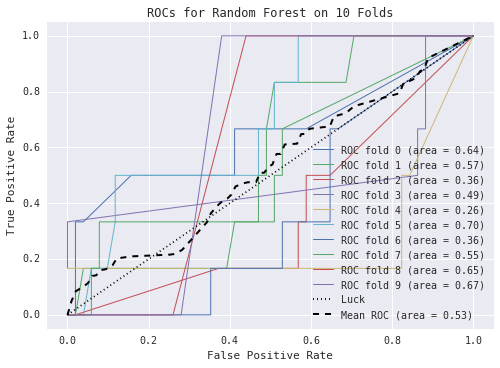

In [11]:
draw_rocs(rf_metrics, 'Random Forest')